<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/torch/ImageRegistor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kornia
#!pip install kornia-rs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 8.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-49-1ccea357e998>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = torch.tensor(imageio.imread(path)).permute(2,0,1).to(torch.float32) / 255


torch.Size([2, 3, 1024, 1024])


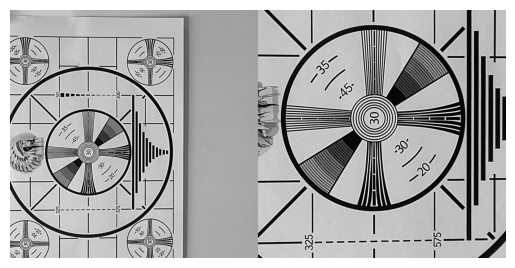

In [49]:
import torch
import imageio

def bchw_from(paths):
    images = []
    for path in paths:
        img = torch.tensor(imageio.imread(path)).permute(2,0,1).to(torch.float32) / 255
        images.append(img)
    return torch.stack(images)

import matplotlib.pyplot as plt
def gimshow(images):   # (b, 3, h, w)
    luminance_weights = torch.tensor([0.2989, 0.5870, 0.1140])
    images = images.permute(1,2,0,3).contiguous().view(images.shape[1], images.shape[2], -1)
    grayscale_image = torch.sum(images.squeeze(0) * luminance_weights.view(3, 1, 1), dim=0)
    plt.imshow(grayscale_image, cmap='gray')
    plt.axis('off')  # Hide the axis
    plt.show()


paths = [
    "/content/drive/MyDrive/indian_head/IMG_0389.JPG",
    "/content/drive/MyDrive/indian_head/IMG_0379.JPG"]

images = bchw_from(paths)

h, w = 1024, 1024

from torchvision.transforms import functional as ttf
images = ttf.center_crop(images, (h, w))
print(images.shape)
gimshow(images)


In [50]:
use_cuda: bool = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


tensor([[[ 0.6441,  0.0016,  0.0924],
         [-0.0016,  0.6441, -0.2560],
         [ 0.0000,  0.0000,  1.0000]]], grad_fn=<CopySlices>)
model.rot Parameter containing:
tensor([0.1455], requires_grad=True)
model.shift Parameter containing:
tensor([[[ 0.0924],
         [-0.2560]]], requires_grad=True)
model.scale Parameter containing:
tensor([0.6441], requires_grad=True)


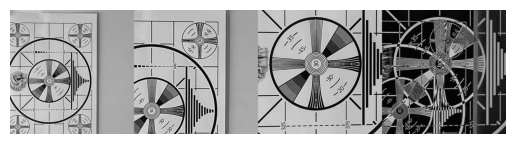

In [52]:
src = images[0].unsqueeze(0)
dst = images[1].unsqueeze(0)

#https://kornia.readthedocs.io/en/latest/geometry.transform.html#kornia.geometry.transform.image_registrator.ImageRegistrator
import torch.optim as optim
import torch.nn.functional as F
import kornia.geometry as kg
registrator = kg.ImageRegistrator("similarity", loss_fn=F.mse_loss,
                                  lr=0.03, optimizer=optim.Adam,
                                  pyramid_levels=3, num_iterations=50).to(device)
homo = registrator.register(src, dst)
print(homo)
for k, v in registrator.named_parameters():
    print(k, v)
src_warped = registrator.warp_src_into_dst(src).detach().cpu()
gimshow(torch.cat([src, src_warped, dst, (dst - src_warped).abs()], dim=0))


In [53]:
class myImageRegistrator(kg.ImageRegistrator):
    def reset_model(self) -> None:
        pass

tensor([[[ 0.5063, -0.0069, -0.3112],
         [ 0.0069,  0.5063,  0.1991],
         [ 0.0000,  0.0000,  1.0000]]], grad_fn=<CopySlices>)
model.rot Parameter containing:
tensor([-0.7799], requires_grad=True)
model.shift Parameter containing:
tensor([[[-0.3112],
         [ 0.1991]]], requires_grad=True)
model.scale Parameter containing:
tensor([0.5063], requires_grad=True)


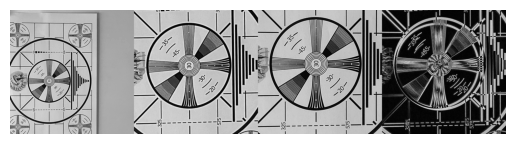

In [86]:
src = images[0].unsqueeze(0)
dst = images[1].unsqueeze(0)

#https://kornia.readthedocs.io/en/latest/geometry.transform.html#kornia.geometry.transform.image_registrator.ImageRegistrator
import torch.optim as optim
import torch.nn.functional as F
import kornia.geometry as kg
registrator = myImageRegistrator("similarity", loss_fn=F.mse_loss,
                                  lr=0.01, optimizer=optim.Adam, tolerance=1e-6,
                                  pyramid_levels=7, num_iterations=100).to(device)
registrator.model.rot = torch.nn.Parameter(torch.tensor([0.0]))
registrator.model.shift = torch.nn.Parameter(torch.tensor([[[-0.2], [0.0]]]))
registrator.model.scale = torch.nn.Parameter(torch.tensor([0.5]))

homo = registrator.register(1.0 - src, 1.0 - dst)
print(homo)
for k, v in registrator.named_parameters():
    print(k, v)
src_warped = registrator.warp_src_into_dst(src).detach().cpu()
gimshow(torch.cat([src, src_warped, dst, (dst - src_warped).abs()], dim=0))


tensor([[[ 4.6833e-01,  2.2501e-04, -3.3718e-01],
         [-2.2501e-04,  4.6833e-01,  2.0876e-01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]], grad_fn=<CopySlices>)
model.rot Parameter containing:
tensor([0.0275], requires_grad=True)
model.shift Parameter containing:
tensor([[[-0.3372],
         [ 0.2088]]], requires_grad=True)
model.scale Parameter containing:
tensor([0.4683], requires_grad=True)


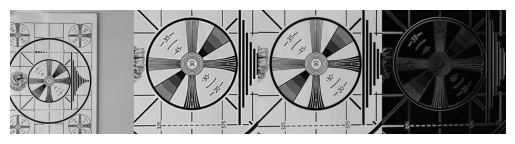

In [89]:
registrator.lr = 0.003
registrator.num_iterations = 300
registrator.loss_fn = F.l1_loss
registrator.tolerance = 1e-6
homo = registrator.register(src, dst)
print(homo)
for k, v in registrator.named_parameters():
    print(k, v)
src_warped = registrator.warp_src_into_dst(src).detach().cpu()
gimshow(torch.cat([src, src_warped, dst, (dst - src_warped).abs()], dim=0))


tensor([[[ 4.6868e-01,  1.7199e-05, -3.3714e-01],
         [-1.7199e-05,  4.6868e-01,  2.0874e-01],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]], grad_fn=<CopySlices>)
model.rot Parameter containing:
tensor([0.0021], requires_grad=True)
model.shift Parameter containing:
tensor([[[-0.3371],
         [ 0.2087]]], requires_grad=True)
model.scale Parameter containing:
tensor([0.4687], requires_grad=True)


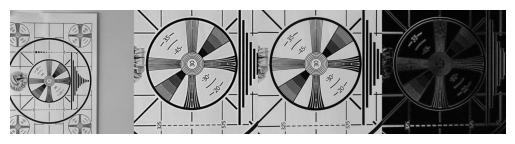

In [90]:
registrator.lr = 0.003
registrator.num_iterations = 1000
registrator.loss_fn = F.mse_loss
registrator.tolerance = 1e-6
homo = registrator.register(src, dst)
print(homo)
for k, v in registrator.named_parameters():
    print(k, v)
src_warped = registrator.warp_src_into_dst(src).detach().cpu()
gimshow(torch.cat([src, src_warped, dst, (dst - src_warped).abs()], dim=0))


In [4]:
import torch
from torchvision.transforms import functional as ttf
import imageio


def load_from_paths(paths):
    images = []
    for path in paths:
        img = torch.tensor(imageio.imread(path)).permute(2,0,1).to(torch.float32) / 255
        images.append(img)
    return torch.tensor(images)




src = imageio.imread("/content/drive/MyDrive/indian_head/IMG_0379.JPG")
src = 1 - torch.tensor(R).permute(2,0,1).unsqueeze(0).to(torch.float32) / 255
src = ttf.center_crop(R, (h, w))

path_src = "/content/drive/MyDrive/indian_head/IMG_0380.JPG"
src, dst = load_src_dst()




<ipython-input-4-f0ecaafb1645>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  R = imageio.imread("/content/drive/MyDrive/indian_head/IMG_0379.JPG")
<ipython-input-4-f0ecaafb1645>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  T = imageio.imread("/content/drive/MyDrive/indian_head/IMG_0380.JPG")
